In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np
import tensorflow as tf

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import scipy.io as sio

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


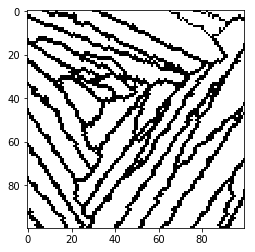

In [2]:
style_img = np.array(sio.loadmat('WB_sm.mat')['WB_sm'],dtype='float32')
content_img = np.array(sio.loadmat('content_img/test_sample.mat')['sample'],dtype='float32')

content_img=style_img[2].reshape(1,100,100,1)
style_img=style_img[1].reshape(1,100,100,1)
plt.imshow(style_img.reshape(100,100),'gray')

In [4]:
height=100;width=100
style_image = backend.variable(style_img)
content_image = backend.variable(content_img)
combination_image = backend.placeholder((1, height, width, 1))

In [5]:
W1 = np.array(sio.loadmat('weights_AE/W1_AE.mat')['weights_1'],dtype='float32')
W2 = np.array(sio.loadmat('weights_AE/W2_AE.mat')['weights_2'],dtype='float32')
W3 = np.array(sio.loadmat('weights_AE/W3_AE.mat')['weights_3'],dtype='float32')

bias1=np.array(sio.loadmat('weights_AE/bias1_AE.mat')['biases_1'],dtype='float32')
bias2=np.array(sio.loadmat('weights_AE/bias2_AE.mat')['biases_2'],dtype='float32')
bias3=np.array(sio.loadmat('weights_AE/bias3_AE.mat')['biases_3'],dtype='float32')

In [6]:
def conv2d(x, W, stride, padding="SAME"):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    
def max_pool(x, k_size, stride, padding="VALID"):
    # use avg pooling instead, as described in the paper
    return tf.nn.avg_pool(x, ksize=[1, k_size, k_size, 1],
                          strides=[1, stride, stride, 1], padding=padding)    

In [7]:
W_conv1 = tf.reshape(tf.constant(W1),[6,6,1,24])
W_conv2 = tf.reshape(tf.constant(W2),[9,9,24,40])
W_conv3 = tf.reshape(tf.constant(W3),[9,9,40,288])

b_conv1 = tf.reshape(tf.constant(bias1),[-1])
b_conv2 = tf.reshape(tf.constant(bias2),[-1])
b_conv3 = tf.reshape(tf.constant(bias3),[-1])
############# white noise ############
conv_out1 = conv2d(combination_image, W_conv1, stride=1, padding='SAME')
conv_out1 = tf.nn.bias_add(conv_out1, b_conv1)
conv_out1 = tf.nn.relu(conv_out1)
conv_out1 = max_pool(conv_out1, k_size=2, stride=2, padding="SAME")

conv_out2 = conv2d(conv_out1, W_conv2, stride=1, padding='SAME')
conv_out2 = tf.nn.bias_add(conv_out2, b_conv2)
conv_out2 = tf.nn.relu(conv_out2)
conv_out2 = max_pool(conv_out2, k_size=2, stride=2, padding="SAME")

conv_out3 = conv2d(conv_out2, W_conv3, stride=1, padding='SAME')
conv_out3 = tf.nn.bias_add(conv_out3, b_conv3)
conv_out3 = tf.nn.relu(conv_out3)

############# style image ############
conv_out1_S = conv2d(style_image, W_conv1, stride=1, padding='SAME')
conv_out1_S = tf.nn.bias_add(conv_out1_S, b_conv1)
conv_out1_S = tf.nn.relu(conv_out1_S)
conv_out1_S = max_pool(conv_out1_S, k_size=2, stride=2, padding="SAME")

conv_out2_S = conv2d(conv_out1_S, W_conv2, stride=1, padding='SAME')
conv_out2_S = tf.nn.bias_add(conv_out2_S, b_conv2)
conv_out2_S = tf.nn.relu(conv_out2_S)
conv_out2_S = max_pool(conv_out2_S, k_size=2, stride=2, padding="SAME")

conv_out3_S = conv2d(conv_out2_S, W_conv3, stride=1, padding='SAME')
conv_out3_S = tf.nn.bias_add(conv_out3_S, b_conv3)
conv_out3_S = tf.nn.relu(conv_out3_S)

############# content image ############
conv_out1_C = conv2d(content_image, W_conv1, stride=1, padding='SAME')
conv_out1_C = tf.nn.bias_add(conv_out1_C, b_conv1)
conv_out1_C = tf.nn.relu(conv_out1_C)
conv_out1_C = max_pool(conv_out1_C, k_size=2, stride=2, padding="SAME")

conv_out2_C = conv2d(conv_out1_C, W_conv2, stride=1, padding='SAME')
conv_out2_C = tf.nn.bias_add(conv_out2_C, b_conv2)
conv_out2_C = tf.nn.relu(conv_out2_C)
conv_out2_C = max_pool(conv_out2_C, k_size=2, stride=2, padding="SAME")

conv_out3_C = conv2d(conv_out2_C, W_conv3, stride=1, padding='SAME')
conv_out3_C = tf.nn.bias_add(conv_out3_C, b_conv3)
conv_out3_C = tf.nn.relu(conv_out3_C)

In [27]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    features_mean = tf.reduce_mean(features,0)
#     features = (features-features_mean)/1
    gram = backend.dot(features, backend.transpose(features))
#     D=tf.sqrt(tf.diag(tf.diag_part(gram)))
#     Q=tf.matmul(tf.matmul(tf.matrix_inverse(D),gram),tf.matrix_inverse(D))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 1
    size = height * width
    return backend.sum(backend.square(S - C)) / 1e-2


style_features1 = conv_out1_S[0,:,:,:]
combination_features1 = conv_out1[0,:,:,:]
style_features2 = conv_out2_S[0,:,:,:]
combination_features2 = conv_out2[0,:,:,:]

sl1 = style_loss(style_features1, combination_features1)
sl2 = style_loss(style_features2, combination_features2)

loss=sl1+sl2

In [28]:
grads = backend.gradients(loss, combination_image)
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 1))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [29]:
x = np.random.uniform(0, 1, (1, height, width, 1))

iterations = 20

for i in range(20):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 15617.2
Iteration 0 completed in 0s
Start of iteration 1
Current loss value: 2400.56
Iteration 1 completed in 0s
Start of iteration 2
Current loss value: 835.462
Iteration 2 completed in 0s
Start of iteration 3
Current loss value: 531.828
Iteration 3 completed in 0s
Start of iteration 4
Current loss value: 359.712
Iteration 4 completed in 0s
Start of iteration 5
Current loss value: 288.46
Iteration 5 completed in 0s
Start of iteration 6
Current loss value: 228.977
Iteration 6 completed in 0s
Start of iteration 7
Current loss value: 197.591
Iteration 7 completed in 0s
Start of iteration 8
Current loss value: 151.956
Iteration 8 completed in 0s
Start of iteration 9
Current loss value: 126.411
Iteration 9 completed in 0s
Start of iteration 10
Current loss value: 111.611
Iteration 10 completed in 0s
Start of iteration 11
Current loss value: 99.8309
Iteration 11 completed in 0s
Start of iteration 12
Current loss value: 92.2708
Iteration 12 completed 

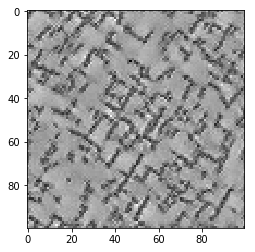

In [30]:
plt.imshow(x.reshape(100,100),'gray')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import scipy.io as sio
import random

from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave


Using TensorFlow backend.


In [3]:

# mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
images = np.array(sio.loadmat('WB_sm.mat')['WB_sm'],dtype='float32')
images = images[0:100]
images[images==0]=-1

mb_size = 20
z_dim = 100/4
X_dim = images.shape[1]
width = 100
hight = 100
h_dim = width/4*hight/4

#variables for correlation function
input_dim = 32
Rad = input_dim/2

conv1_features=64*2
conv2_features=32*2
conv3_features=1
c = 0

num_channels_1=1
num_channels_2=64*2
num_channels_3=32*2
lr = 1e-3


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(width, hight), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

def Q(X):
#     conv1 = tf.nn.conv2d(X, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
#     h1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
#     h1 = tf.reshape(h1,[mb_size,X_dim])
    
    h = tf.nn.relu(tf.matmul(tf.reshape(X,[mb_size,X_dim]), Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar

def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

def P(z):
    h1 = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    h2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h1,[mb_size, width/4, hight/4, 1]), 
                                                  deconv1_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/2, hight/2, conv1_features]),deconv1_bias))
#     h2 = build_unpool(h2_conv, [1, 2, 2, 1])
    
    h3 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h2,[mb_size, width/2, hight/2, conv1_features]), 
                                                  deconv2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, hight/1, conv2_features]),deconv2_bias))
    
    h4 = (tf.add(tf.nn.conv2d_transpose(tf.reshape(h3,[mb_size, width/1, hight/1, conv2_features]), 
                                                  deconv3_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, hight/1, conv3_features]),deconv3_bias))
    
    prob = tf.nn.sigmoid(h4)
    return prob

In [ ]:
# =============================== Q(z|X) ======================================

with tf.variable_scope("VAE"):
    # X = tf.placeholder(tf.float32, shape=[None, X_dim])
    z = tf.placeholder(tf.float32, shape=[None, z_dim])
    x_input_shape = (mb_size, width, hight, num_channels_1)
    X = tf.placeholder(tf.float32, shape=x_input_shape)

    # conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features],
    #                                                stddev=0.1, dtype=tf.float32))
    # conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

    Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]),name="Q_W1")
    Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]),name="Q_b1")

    Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]),name="Q_W2_mu")
    Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]),name="Q_b2_mu")

    Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]),name="Q_W2_sigma")
    Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]),name="Q_b2_sigma")


    # =============================== P(X|z) ======================================

    P_W1 = tf.Variable(xavier_init([z_dim, h_dim]),name="P_W1")
    P_b1 = tf.Variable(tf.zeros(shape=[h_dim]),name="P_b1")

    # P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
    # P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

    deconv1_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, num_channels_1],
                                                   stddev=0.1, dtype=tf.float32),name="deconv1_weight")
    deconv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32),name="deconv1_bias")

    deconv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_features,num_channels_2],
                                                   stddev=0.1, dtype=tf.float32),name="deconv2_weight")
    deconv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32),name="deconv2_bias")

    deconv3_weight = tf.Variable(tf.truncated_normal([4, 4, conv3_features, num_channels_3],
                                                   stddev=0.1, dtype=tf.float32),name="deconv3_weight")
    deconv3_bias = tf.Variable(tf.zeros([conv3_features], dtype=tf.float32),name="deconv3_bias")


# =============================== TRAINING ====================================

z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
prob = P(z_sample)

# Sampling from random z
X_samples = P(z)

# point correlation loss
# PC_ori=correlation_fun(X, input_dim=input_dim, Rad=Rad)
# PC_rec=correlation_fun(prob, input_dim=input_dim, Rad=Rad)
# PC_ran=correlation_fun(X_samples,input_dim=input_dim, Rad=Rad)

# PC_loss1=tf.abs(PC_ori-PC_rec)
# PC_loss2=tf.abs(PC_ori-PC_ran)

# E[log P(X|z)]
recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square((tf.reshape(prob,[mb_size, X_dim])-
                                                     tf.reshape(X,[mb_size, X_dim]))), 1))/4
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss =tf.reduce_mean(0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1))

# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

grads = backend.gradients(vae_loss, [prob])


















solver0 = tf.train.AdamOptimizer(learning_rate=lr).minimize(vae_loss)
solver1 = tf.train.AdamOptimizer(learning_rate=lr/10).minimize(vae_loss)
solver2 = tf.train.AdamOptimizer(learning_rate=lr/100).minimize(vae_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0
PC_ori=[]
saver = tf.train.Saver()

for it in range(400000):
    X_mb = images[random.sample(range(len(images)),  mb_size)]
#     PC_ori = tf.reduce_mean(tf.concat([PC_ori, PC_ori_temp],0))
        
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss, recon_E, kl_E = sess.run([solver0, vae_loss, recon_loss, kl_loss], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim)})
    
    if it % 250 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        
        print()

        samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})

#         fig = plot(samples)
#         plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
#         i += 1
#         plt.close(fig)
save_path = saver.save(sess, "/tmp/model.ckpt")